In [1]:
# -*- coding: utf-8 -*-
import os
import glob 
import pandas as pd
import string
import collections
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from Gen.chinese_data import common_chinese_chars
from bnn_layer import BLinear, BConv2d, HLinear, BLSTM, QLinear, QConv2d
from crnn import CaptchaDataset, BCRNN, Engine, QCRNN

char_num:311


In [2]:
path = r'.\\data\\chinese\\new_data'
labels_file = f'{path}\\labels.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
all_letters = common_chinese_chars
mapping = {}
mapping_inv = {}
i = 1
for x in all_letters:
    mapping[x] = i
    mapping_inv[i] = x
    i += 1
num_class = len(mapping)

In [4]:
# mapping
# mapping_inv

In [5]:
images = []
labels = []
datas = collections.defaultdict(list)
data_len = 0
with open(labels_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        image_name, chinese_text = line.split(',')
        chinese_chars = list(chinese_text)
        datas['image'].append(image_name)
        datas['label'].append([mapping[i] for i in chinese_chars])
        data_len += 1
df = pd.DataFrame(datas)
df.head()

,image,label
0,00000.png,"[286, 287, 288, 289, 290]"
1,00001.png,"[291, 292, 293, 294, 295]"
2,00002.png,"[296, 297, 298, 298, 299]"
3,00003.png,"[300, 301, 297, 302, 303]"
4,00004.png,"[304, 305, 306, 297, 307]"


In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)
len(df)

10500

In [7]:
transform = T.Compose([T.ToTensor()])
train_data = CaptchaDataset(df_train, transform, path)
test_data = CaptchaDataset(df_test, transform, path)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [8]:
model = BCRNN(in_channels=1, output=num_class).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CTCLoss()
engine = Engine(model, optimizer, criterion, epochs=500, device=DEVICE)

In [9]:
engine.fit(train_loader)
outs, loss = engine.evaluate(test_loader)

100%|██████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 58.59it/s, Loss=0.249]


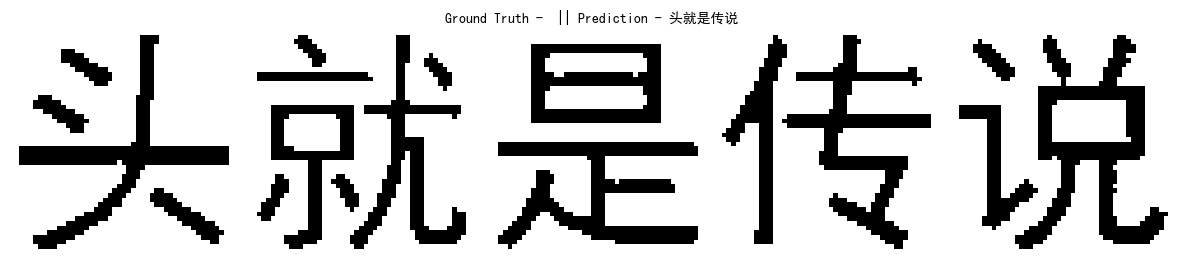

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

font_path = ".\\Gen\\font\\SimHei.ttf"  # 替换成你的中文字体文件路径
myfont = FontProperties(fname=font_path)

ids = np.random.randint(data_len)
padded_ids = str(ids).zfill(5)
image = os.path.join(path, f"{padded_ids}.png")
out = engine.predict(image)[0]

def show_prediction(out, image):
    gt = image.split('/')[-1].split('.')[0]
    imagePIL = Image.open(image).convert('L')

    pred = ''
    then = 0
    for x in out:
        if then != x:
            if x > 0 :
                pred += mapping_inv[x]
        then = x

    plt.figure(figsize=(15, 12))
    img_array = np.asarray(imagePIL)
    plt.title(f'Ground Truth - {gt} || Prediction - {pred}',fontproperties=myfont)
    plt.axis('off')
    plt.imshow(img_array,cmap='gray')
    
show_prediction(out, image)

In [11]:
out

array([  0, 103,   0,   0, 171,   0,   0,  58,   0,   0, 237,   0,   0,
         0, 117], dtype=int64)

In [12]:
saving = {'state_dict':engine.model.state_dict(),
          'optimizer':engine.optimizer.state_dict(),
         'mapping':mapping,
         'mapping_inv':mapping_inv}
torch.save(saving, './model/BNN_B_small.pth')